In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.constants as cst
from scipy.optimize import fsolve, root_scalar
from scipy import linalg
from numpy import sin, cos, sqrt, pi
import copy

from qnlmodels.snail import Snail

In [2]:
# Constants
e0 = 8.854e-12 #F / m
kB = 1.380649e-23 # Boltzmann const
hbar = 1.054571817e-34
h = 6.62607015e-34
q = 1.602176634e-19
e = q
phi0 = h / 2 / q

In [3]:
class dispersion_in_parasitic_JJ_metamaterial:
# Class Declaration (Adapted from https://github.com/arpitranadive/JJ_metamaterial_simulation/blob/master/dispersion_and_gain_in_TWPAs.py)

	def __init__(self):

		self.version = '0.1.1'

		self.pump_frequency = None				# in GHz
		self.incident_pump_amplitude = None		
		self.phi_ext = np.pi					# external magnetic flux in the loop		

		self.loss_tangent = None				# loss tangent
		self.number_of_loops = None				# number of loops in the transmission line
		self.size_of_one_loop = None			# size of one SNAIL loop in m
		self.I0 = None							# critical current of large junction
		self.I0_ratio = None					# ratio of critical currents in the SNAIL
		self.C_g = None							# ground capacitance
		self.C_J = None							# junction capacitance

		self.gamma = None						# kerr nonlinearity
		self.L_loop = None						# loop inductance
		self.Lp = None
		self.noise = None
		self.Zchar = None

		self.phi_0 = h / (2 * e)



	def linear_to_dB(self,linear):

		return 10*(np.log10(linear))


	def I(self,phi_s):

		return self.I0_ratio*self.I0*np.sin(phi_s)+self.I0*np.sin((phi_s-self.phi_ext)/3.0)


	def calculate_loop_parameters(self):

		phi_smin = fsolve(self.I, 0)
		gamma_tilde = (1.0/6)*(self.I0_ratio*np.cos(phi_smin)+(1.0/27)*np.cos((phi_smin-self.phi_ext)/3.0))
		alpha_tilde = self.I0_ratio*np.cos(phi_smin)+(1.0/3)*np.cos((phi_smin-self.phi_ext)/3.0)
		self.gamma = gamma_tilde/alpha_tilde
		self.L_loop = abs(1.0*self.phi_0/(alpha_tilde*self.I0*2*np.pi))
	
		if self.Lp:
			self.L_loop = self.L_loop / (1+self.Lp/self.L_loop)
		self.Zchar = np.sqrt(self.L_loop/self.C_g)


	def phase_mismatch(self,w_s):

		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		gamma = self.gamma
		L_loop = self.L_loop
		C_g = self.C_g
		C_J = self.C_J

		w_p = pump_frequency*1e9*2*np.pi
		w_i = 2*w_p-w_s
		w_0 = 1.0/(np.sqrt(L_loop*C_g))
		w_J = 1.0/(np.sqrt(L_loop*C_J))
		k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
		k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
		k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
		w_til_p = 1-(w_p/w_J)**2
		w_til_s = 1-(w_s/w_J)**2
		w_til_i = 1-(w_i/w_J)**2
		k_p_loss = loss_tangent*k_p/2
		pump_amplitude_reduced = pump_amplitude*np.exp(-k_p_loss*self.number_of_loops/2)
		eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
		eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
		eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
		del_k_disp = 2*k_p-k_i-k_s
		del_kerr = 2*eta_p-eta_i-eta_s
		del_k_total = del_k_disp + del_kerr
		return del_k_disp, del_kerr, del_k_total


	def phase_mismatch_vs_frequency(self,freq_array):
		
		del_k_disp_array = np.array([])
		del_k_kerr_array = np.array([])
		del_k_total_array = np.array([])

		for freq in freq_array:

			del_k_disp, del_kerr, del_k_total = self.phase_mismatch(freq*1e9*2*np.pi)
			del_k_disp_array = np.append(del_k_disp_array,del_k_disp)
			del_k_kerr_array = np.append(del_k_kerr_array,del_kerr)
			del_k_total_array = np.append(del_k_total_array,del_k_total)

		return del_k_disp_array/self.size_of_one_loop, del_k_kerr_array/self.size_of_one_loop, del_k_total_array/self.size_of_one_loop


	def gain(self,w_s):

		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		gamma = self.gamma
		L_loop = self.L_loop
		C_g = self.C_g
		C_J = self.C_J
		number_of_loops = self.number_of_loops

		w_p = pump_frequency*1e9*2*np.pi
		w_i = 2*w_p-w_s
		w_0 = 1.0/(np.sqrt(L_loop*C_g))
		w_J = 1.0/(np.sqrt(L_loop*C_J))
		k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
		k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
		k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
		w_til_p = 1-(w_p/w_J)**2
		w_til_s = 1-(w_s/w_J)**2
		w_til_i = 1-(w_i/w_J)**2
		k_p_loss = loss_tangent*k_p/2
		pump_amplitude_reduced = pump_amplitude*np.exp(-k_p_loss*number_of_loops/2)
		eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
		eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
		eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
		del_k_disp = 2*k_p-k_i-k_s
		del_kerr = 2*eta_p-eta_i-eta_s
		del_k_total = del_k_disp + del_kerr

		k_i_loss = loss_tangent*k_i/2
		k_s_loss = loss_tangent*k_s/2
		Phi11 = -1j*0.5*del_k_total-k_s_loss
		Phi12 = 1j*eta_s*k_i/(k_s*2)
		Phi21 = -1j*eta_i*k_s/(k_i*2)
		Phi22 = 1j*0.5*del_k_total-k_i_loss
		matrix_Phi = np.array([[Phi11[0],Phi12[0]],[Phi21[0],Phi22[0]]])
		
		exp_Phi = linalg.expm(matrix_Phi*number_of_loops)

		if self.noise:
			exp_Phi[0][0] += np.sqrt(complex(k_s_loss))/2/np.pi
			exp_Phi[1][1] += np.sqrt(complex(k_i_loss))/2/np.pi
		
		gain_lin = abs(exp_Phi[0][0])**2

		return self.linear_to_dB(gain_lin)
	
	def gain_for_Cg_range(self, w_s, Cg_values):

		if len(Cg_values) != self.number_of_loops: return "Each cell must have a capacitance value, but there are {:.0f} cells and {:.0f} capacitances".format(self.number_of_loops, len(Cg_values))
		
		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		C_J = self.C_J
		gamma = self.gamma
		L_loop = self.L_loop

		w_p = pump_frequency*1e9*2*np.pi
		w_i = 2*w_p-w_s
		w_J = 1.0/(np.sqrt(L_loop*C_J))
		w_til_p = 1-(w_p/w_J)**2
		w_til_s = 1-(w_s/w_J)**2
		w_til_i = 1-(w_i/w_J)**2

		pump_amplitude_reduced = pump_amplitude

		for Cg in Cg_values:
			# self.C_g = Cg
			
			w_0 = 1.0/(np.sqrt(L_loop*Cg))
			
			k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
			k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
			k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))

			k_p_loss = loss_tangent*k_p/2

			pump_amplitude_reduced = pump_amplitude_reduced*np.exp(-k_p_loss/2)
		net_matrix_Phi = np.zeros((2,2))
		
		for Cg in Cg_values:
			# self.C_g = Cg

			w_0 = 1.0/(np.sqrt(L_loop*Cg))

			k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
			k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
			k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))

			k_p_loss = loss_tangent*k_p/2

			eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
			eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
			eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
			
			del_k_disp = 2*k_p-k_i-k_s
			del_kerr = 2*eta_p-eta_i-eta_s
			del_k_total = del_k_disp + del_kerr

			k_i_loss = loss_tangent*k_i/2
			k_s_loss = loss_tangent*k_s/2
			Phi11 = -1j*0.5*del_k_total-k_s_loss
			Phi12 = 1j*eta_s*k_i/(k_s*2)
			Phi21 = -1j*eta_i*k_s/(k_i*2)
			Phi22 = 1j*0.5*del_k_total-k_i_loss
			matrix_Phi = np.array([[Phi11[0],Phi12[0]],[Phi21[0],Phi22[0]]])
			net_matrix_Phi = np.add(net_matrix_Phi,matrix_Phi)
		
		exp_Phi = linalg.expm(net_matrix_Phi)

		if self.noise:
			exp_Phi[0][0] += np.sqrt(complex(k_s_loss))/2/np.pi
			exp_Phi[1][1] += np.sqrt(complex(k_i_loss))/2/np.pi
		
		gain_lin = abs(exp_Phi[0][0])**2

		return self.linear_to_dB(gain_lin)
	
	def gain_for_ratio_range(self, w_s, r_values):

		if len(r_values) != self.number_of_loops: return "Each cell must have a ratio value, but there are {:.0f} cells and {:.0f} ratios".format(self.number_of_loops, len(r_values))
		
		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		C_J = self.C_J
		Cg = self.C_g

		pump_amplitude_reduced = pump_amplitude
		
		for r in r_values:

			self.I0_ratio = r
			self.calculate_loop_parameters()
			gamma = self.gamma
			L_loop = self.L_loop

			w_p = pump_frequency*1e9*2*np.pi
			w_i = 2*w_p-w_s
			w_J = 1.0/(np.sqrt(L_loop*C_J))
			w_til_p = 1-(w_p/w_J)**2
			w_til_s = 1-(w_s/w_J)**2
			w_til_i = 1-(w_i/w_J)**2
			
			w_0 = 1.0/(np.sqrt(L_loop*Cg))
			
			k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
			k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
			k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))

			k_p_loss = loss_tangent*k_p/2

			pump_amplitude_reduced = pump_amplitude_reduced*np.exp(-k_p_loss/2)

		net_matrix_Phi = np.zeros((2,2))
		
		for r in r_values:
			
			self.I0_ratio = r
			self.calculate_loop_parameters()
			gamma = self.gamma
			L_loop = self.L_loop

			w_p = pump_frequency*1e9*2*np.pi
			w_i = 2*w_p-w_s
			w_J = 1.0/(np.sqrt(L_loop*C_J))
			w_til_p = 1-(w_p/w_J)**2
			w_til_s = 1-(w_s/w_J)**2
			w_til_i = 1-(w_i/w_J)**2

			w_0 = 1.0/(np.sqrt(L_loop*Cg))

			k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
			k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
			k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))

			k_p_loss = loss_tangent*k_p/2

			eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
			eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
			eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
			
			del_k_disp = 2*k_p-k_i-k_s
			del_kerr = 2*eta_p-eta_i-eta_s
			del_k_total = del_k_disp + del_kerr

			k_i_loss = loss_tangent*k_i/2
			k_s_loss = loss_tangent*k_s/2
			Phi11 = -1j*0.5*del_k_total-k_s_loss
			Phi12 = 1j*eta_s*k_i/(k_s*2)
			Phi21 = -1j*eta_i*k_s/(k_i*2)
			Phi22 = 1j*0.5*del_k_total-k_i_loss
			matrix_Phi = np.array([[Phi11[0],Phi12[0]],[Phi21[0],Phi22[0]]])
			net_matrix_Phi = np.add(net_matrix_Phi,matrix_Phi)
		
		exp_Phi = linalg.expm(net_matrix_Phi)

		if self.noise:
			exp_Phi[0][0] += np.sqrt(complex(k_s_loss))/2/np.pi
			exp_Phi[1][1] += np.sqrt(complex(k_i_loss))/2/np.pi
		
		gain_lin = abs(exp_Phi[0][0])**2

		return self.linear_to_dB(gain_lin)


	def gain_vs_freq(self,freq_array):
		
		gain_array = np.array([])

		for freq_s in freq_array:

			w_s = freq_s*1e9*2*np.pi
			gain_array = np.append(gain_array,self.gain(w_s))

		return gain_array

	# Custom Plotting Functions

	def gain_vs_ground_cap(self, cap_array, w_s):
		
		gain_array = np.array([])
		w_s = w_s*1e9*2*np.pi

		for Cg in cap_array:
			self.I0_ratio = Cg
			self.calculate_loop_parameters()
			gain_array = np.append(gain_array,self.gain(w_s))

		return gain_array

	def plot_g4_vs_flux(self, flux_range):
		g4s = []
		for flux_ratio in flux_range:
			self.phi_ext = 2*np.pi*flux_ratio
			self.calculate_loop_parameters()
			g4s.append(self.gamma * q**2 / 4 / self.C_g / hbar * 1e-6) #MHz

		plt.figure(figsize=(8, 6))
		plt.plot(flux_range, g4s)
		plt.xlabel('Quantized Flux')
		plt.ylabel('g4 (MHz)')
		plt.grid(True)
		plt.show()

In [4]:
### UTILS ###
# Conversion Functions
def dbm_to_watts(Pdbm):
    return 10**((Pdbm - 30) / 10)  # Convert dBm to Watts

def watts_to_dbm(Pw):
    return 10 * np.log10(Pw) + 30  # Convert Watts to dBm

def Irms_to_power(Z0, Irms):
    return Irms**2 * Z0  # Power in watts

def power_to_Irms(Z0, Pw):
    return np.sqrt(Pw / Z0)  # Current in amps

# pump power from incident amplidute (undepleted approximation)
def power_from_amplitude(A0: float = 1.8, 
                         Z0: float = 50, 
                         wp: float = 10) -> tuple:
    Pwatts = A0 ** 2 * (2 * np.pi * wp)**2 / Z0 * hbar / 2
    return Pwatts, watts_to_dbm(Pwatts)

def amplitude_from_power(Pdbm, Z0, w):
    Pwatts = dbm_to_watts(Pdbm)
    return np.sqrt(Pwatts / (2 * np.pi * w)**2 * Z0 * 2 / hbar)

# Gain depletion approximation
def gain_depletion(G0, Is, Ip):
    return G0 / (1 + 2 * G0 * Is**2 / Ip**2)

# Gain stats
def gain_stats (low_freq, high_freq, freq_values, gain_values):
    freq_indices = np.where(np.logical_and(freq_values>=low_freq, freq_values<=high_freq))
    gain_per_frequency = [] 
    for i in freq_indices[0]:
        gain_per_frequency+=[gain_values[i]]
    return np.sum(gain_per_frequency)*(high_freq-low_freq)/len(gain_per_frequency), np.sum(gain_per_frequency)/len(gain_per_frequency), np.max(gain_per_frequency)

In [5]:
amplitude_from_power(-110, 50, 7e9*2*np.pi)

0.35237423242996774

In [6]:
Z0=50
#Conversion tests
incident_signal_power = -130 #dBm
print('Incident signal power: ', incident_signal_power, 'dBM')
print('Incident signal current: ', f'{power_to_Irms(Z0, dbm_to_watts(incident_signal_power))*1e9:.2f}', 'nA')

attenuators = {'4K':-20, '100mK':-10, '20mK':-10}
print('Attentuators' , [attenuators[key] for key in attenuators.keys()])

input_signal_power_dBm = incident_signal_power - np.sum([attenuators[key] for key in attenuators.keys()])
input_signal_power_watts = dbm_to_watts(input_signal_power_dBm)
print('Input signal power: ', input_signal_power_watts*1e12, 'pW') #nW
print('Input signal current: ', f'{power_to_Irms(Z0, input_signal_power_watts)*1e6:.2f}', 'uA')


print('\n')
reported_pump_power_dbm = -76
print('Pump power: ', reported_pump_power_dbm, 'dBm')

reported_pump_power_watts = dbm_to_watts(reported_pump_power_dbm)
print('\t', f'{reported_pump_power_watts*1e12:.2f}', 'pW') #nW
print('Pump current: ', f'{power_to_Irms(Z0, reported_pump_power_watts)*1e6:.2f}', 'uA')

print('\nOr\n')
incident_pump_current = 0.7e-6 * np.sqrt(2)
incident_pump_current_rms = incident_pump_current / np.sqrt(2)
print('Pump current (rms): ', incident_pump_current_rms*1e6, 'uA')

incident_pump_power = Irms_to_power(Z0, incident_pump_current_rms)

print('Incident pump power: ',incident_pump_power*1e12, 'pW')
print('\t', watts_to_dbm(incident_pump_power), 'dBM')

Incident signal power:  -130 dBM
Incident signal current:  1.41 nA
Attentuators [-20, -10, -10]
Input signal power:  1.0 pW
Input signal current:  0.14 uA


Pump power:  -76 dBm
	 25.12 pW
Pump current:  0.71 uA

Or

Pump current (rms):  0.7 uA
Incident pump power:  24.499999999999996 pW
	 -76.10833915635467 dBM


In [7]:
### Final TWPA parameters ###
J0 = 1.2e-6
junction_area = 0.88 * 2

I0 = J0 * junction_area

pump_power = -92 #dBm
wp = 10 #GHz
Zchar = 50

print("Pump current:",power_to_Irms(Zchar, dbm_to_watts(pump_power))*1e6, 'uA')

sim_params = {
    'pump_frequency': wp, #GHz
    'incident_pump_amplitude': amplitude_from_power(pump_power, Zchar, wp*2*pi*1e9),
    'loss_tangent': 1e-5,
    'number_of_loops': 375,
    'size_of_one_loop': 160e-6, #m
    'I0': I0, #A
    'I0_ratio': 0.095, 
    'C_g': 240e-15, #F
    'C_J': 70e-15, #F
    'Lp': 60e-12 #H
}

for key, value in sim_params.items():
    print(key, value)

Pump current: 0.1123349762522959 uA
pump_frequency 10
incident_pump_amplitude 1.959305614058941
loss_tangent 1e-05
number_of_loops 375
size_of_one_loop 0.00016
I0 2.112e-06
I0_ratio 0.095
C_g 2.4e-13
C_J 7e-14
Lp 6e-11


Range = 2.00 to 14.00 GHz
Max gain = 118.7 at 5.73 GHz
Avg gain = 64.8
GBP = 777.0
Leff = 598.862 pH
Z0 = 49.953 Ohms
Ip = 2464475128.363 A
w0 = 83.413 GHz
wj = 154.450 GHz
Init Reflection Coefficient = -0.0004748


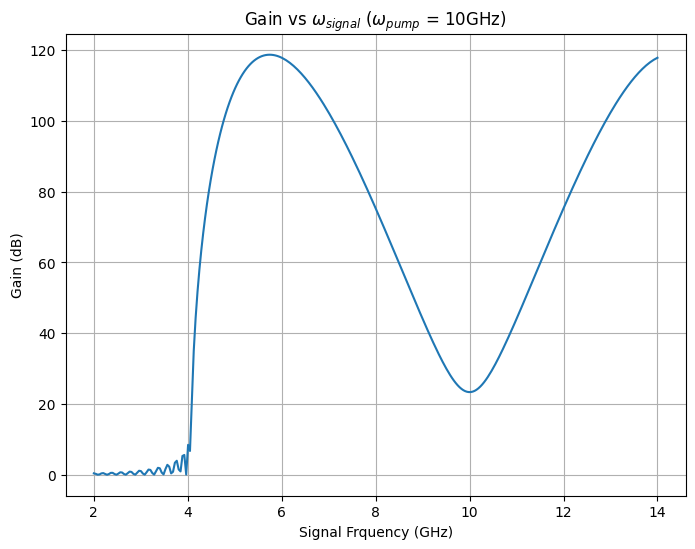

In [8]:
### Gain Simulation -- Ideal Parameters ###
# Create a copy of sim with original parameters
sim_original = copy.deepcopy(dispersion_in_parasitic_JJ_metamaterial())

for key, value in sim_params.items():
    setattr(sim_original, key, value)
sim_original.calculate_loop_parameters()

low_freq = 2
high_freq = 14

omega_s_range = np.linspace(low_freq, high_freq, 300)

gain_values = sim_original.gain_vs_freq(omega_s_range)

GBP, avg_gain, max_gain = gain_stats(low_freq, high_freq, omega_s_range, gain_values)

print("Range = {:.2f} to {:.2f} GHz".format(low_freq, high_freq))
print("Max gain = {:.1f} at {:.2f} GHz".format(max_gain, omega_s_range[np.where(gain_values==np.max(gain_values))[0][0]]))
print("Avg gain = {:.1f}".format(avg_gain))
print("GBP = {:.1f}".format(GBP))

print("Leff = {:.3f} pH".format(sim_original.L_loop[0]*1e12))
print("Z0 = {:.3f} Ohms".format(np.sqrt(sim_original.L_loop[0]/sim_original.C_g)))
print("Ip = {:.3f} A".format(sim_original.incident_pump_amplitude*2*np.pi*1e9*sim_original.pump_frequency/np.sqrt(sim_original.L_loop[0]/sim_original.C_g)))
print("w0 = {:.3f} GHz".format(1e-9/np.sqrt(sim_original.L_loop[0]*sim_original.C_g)))
print("wj = {:.3f} GHz".format(1e-9/np.sqrt(sim_original.L_loop[0]*sim_original.C_J)))
print("Init Reflection Coefficient = {:.7f}".format((np.sqrt(sim_original.L_loop[0]/sim_original.C_g)-50)/(np.sqrt(sim_original.L_loop[0]/sim_original.C_g)+50)))

plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, gain_values)
plt.xlabel('Signal Frquency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_{signal}$ ($\omega_{pump}$ = 10GHz)')
plt.grid(True)
plt.show()

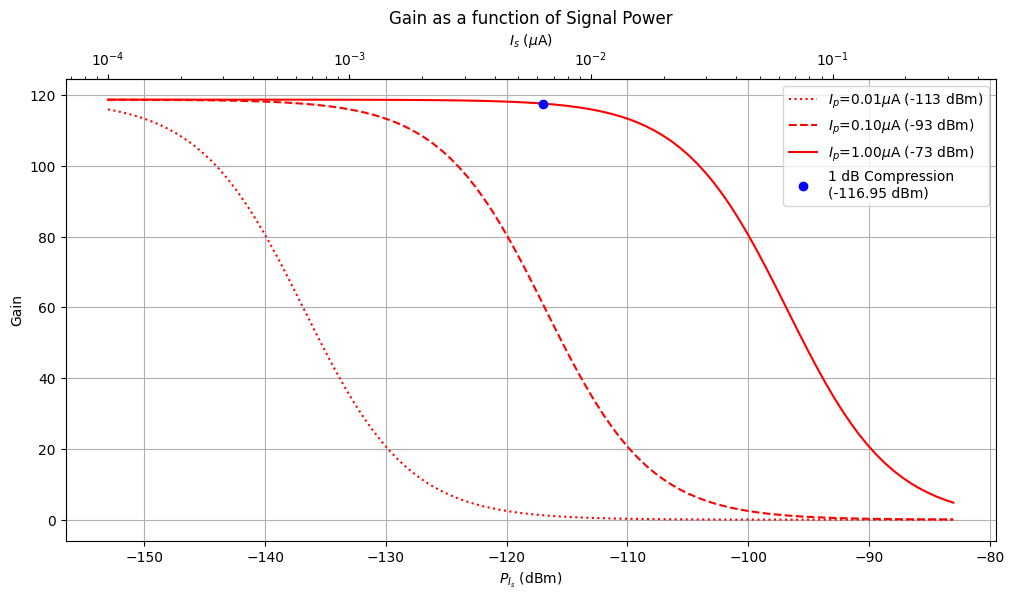

In [9]:
sim = copy.deepcopy(dispersion_in_parasitic_JJ_metamaterial())
for key, value in sim_params.items():
    setattr(sim, key, value)
sim.calculate_loop_parameters()

# Parameters
Z0 = sim.Zchar  #Impedance in Ohms
G0 = np.max([sim.gain(ws*1e9*2*np.pi) for ws in omega_s_range]) # Set max gain value
Is_values = np.logspace(-10, -6.5, 100)  # Is from 1e-9 to 1e-5 (log scale)
Ip_values = np.logspace(-8, -4.5, 100)  # Ip from 1e-9 to 1e-5 (log scale)

# Fixed Ip for plotting Gain vs Is
Ip_range = np.logspace(-8, -6, 3)
plot_legend = ['r:', 'r--', 'r-']

# Create plots
fig = plt.figure(figsize=(12, 6))

# Plot 1: Gain as a function of Is (in dBm)
ax = fig.add_subplot()

for Ip_fixed, legend in zip(Ip_range, plot_legend):
    # Depleted gain approximation as a function of Is
    gain_is = gain_depletion(G0, Is_values, Ip_fixed)

    # Convert Is (current) to power (dBm)
    Is_power = Irms_to_power(Z0, Is_values)
    Is_power_dBm = watts_to_dbm(Is_power)

    # Fixed Is for plotting Gain vs Ip
    Is_fixed = 1e-8
    gain_ip = gain_depletion(G0, Is_fixed, Ip_values)

    # Convert Ip (current) to power (dBm)
    Ip_power = Irms_to_power(Z0, Ip_values)
    Ip_power_dBm = watts_to_dbm(Ip_power)

    ax.plot(Is_power_dBm, gain_is, legend, label=f'$I_p$={Ip_fixed*1e6:.2f}$\mu$A ({watts_to_dbm(Irms_to_power(Z0, Ip_fixed))[0]:.0f} dBm)')

ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'$P_{I_s}$ (dBm)')
ax.set_ylabel('Gain')
ax.set_title(r'Gain as a function of Signal Power')
secax = ax.secondary_xaxis('top', functions=(lambda P: power_to_Irms(Z0, dbm_to_watts(P))*1e6, lambda I: watts_to_dbm(Irms_to_power(Z0, I*1e-6))))
secax.set_xlabel(r'$I_s$ ($\mu$A)')
secax.set_xscale('log')

# Find the max gain and 1 dB compression point
max_gain = np.max(gain_is)  # Max gain
compression_gain = max_gain - 1  # 1 dB less than max gain

# Find the input power at which the gain is 1 dB less than the maximum
compression_power_idx = np.where(gain_is <= compression_gain)[0][0]  # Find index where gain drops
compression_power = Is_power_dBm[compression_power_idx]  # Corresponding power in dBm
compression_gain_value = gain_is[compression_power_idx]  # Gain at compression point

# Mark the 1 dB compression point on the plot
plt.plot(compression_power, compression_gain_value, 'bo', label=f'1 dB Compression\n({compression_power:.2f} dBm)')

plt.grid(True)
plt.legend()

plt.show()

Pump power: -75 dBm
Pump current: 0.80 uA
1e-09
1e-06


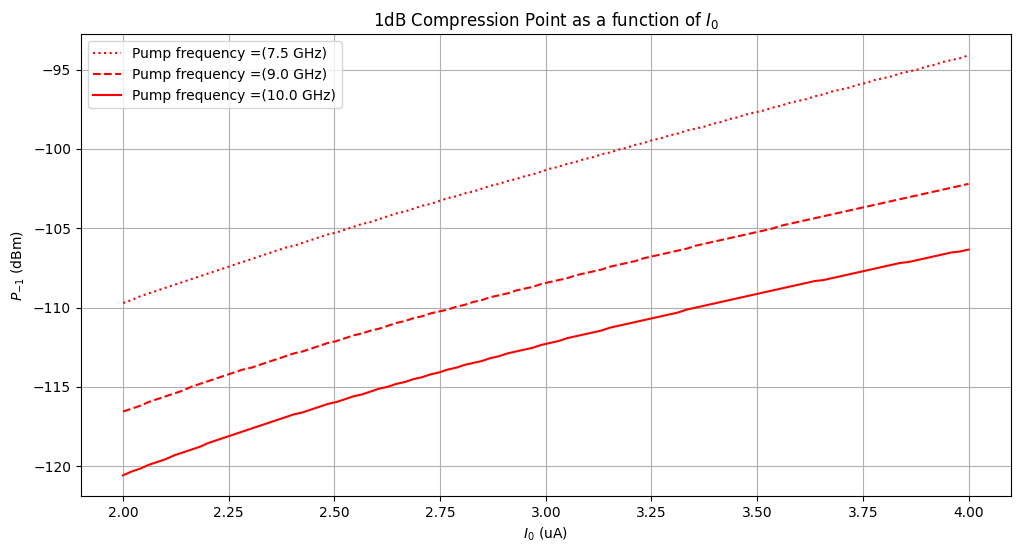

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Parameters
Pp = -75 # Pump power in dBm
Pp_watts = dbm_to_watts(Pp) #Pump power in watts
Ip = power_to_Irms(Z0, Pp_watts) # Pump current in Amps
print('Pump power:', Pp, 'dBm')
print('Pump current:', f'{Ip[0]*1e6:.2f}', 'uA')

Is_values = np.logspace(-9, -6, 1000)  # Is from 1e-9 to 1e-5 (log scale)
print(Is_values[0])
print(Is_values[-1])
# Convert Is (current) to power (dBm)
Is_power = Irms_to_power(Z0, Is_values)
Is_power_dBm = watts_to_dbm(Is_power)

I0_range = np.linspace(2e-6, 4e-6, 100)  # I0 (log scale)
wp_values = [7.5, 9, 10]
plot_legend = ['r:', 'r--','r-']
ws_range = np.linspace(5, 10, 200)

sim = copy.deepcopy(dispersion_in_parasitic_JJ_metamaterial())
for key, value in sim_params.items():
    setattr(sim, key, value)

# Create plots
plt.figure(figsize=(12, 6))

for wp, legend in zip(wp_values, plot_legend):
    compression_power = []
    setattr(sim, 'pump_frequency', wp)
    for I0 in I0_range:
        setattr(sim, 'I0', I0)
        sim.calculate_loop_parameters()

        # Set max gain value
        G0 = np.max([sim.gain(ws*1e9*2*np.pi) for ws in ws_range])
        # Get corresponding depletion as function of Is
        gain_is = gain_depletion(G0, Is_values, Ip)
        compression_gain = G0 - 1  # 1 dB less than max gain

        # Find the input power at which the gain is 1 dB less than the maximum
        compression_power_idx = np.where(gain_is <= compression_gain)[0][0]  # Find index where gain drops
        # print(compression_power_idx)
        compression_power.append(Is_power_dBm[compression_power_idx])  # Corresponding power in dBm
        # compression_gain_value = gain_is[compression_power_idx]  # Gain at compression point
    # Plot 1dB compression power as a function of I0
    plt.plot(I0_range*1e6, compression_power, legend, label=f'Pump frequency =({wp:.1f} GHz)')  

plt.xscale('linear')
plt.yscale('linear')
plt.xlabel(r'$I_0$ (uA)')
plt.ylabel(r'$P_{-1}$ (dBm)')
plt.title(r'1dB Compression Point as a function of $I_0$')
plt.grid(True)
plt.legend()

In [11]:
pump_current = 1e-6
Z0 = 50
wp = 10e9
Ap0 = pump_current*Z0/wp
print(Ap0)

4.999999999999999e-15


Range = 2.00 to 14.00 GHz
Max gain = 128.4 at 5.57 GHz
Avg gain = 70.9
GBP = 850.5
L = 598.862 pH
Z0 = 49.953 Ohms
w0 = 83.413 GHz
wj = 154.450 GHz
Init Reflection Coefficient = -0.0004748


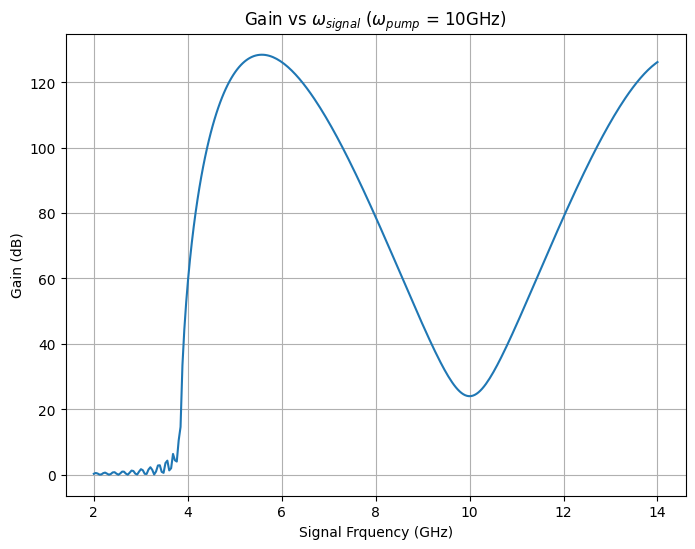

In [12]:
### Gain Simulation -- stochastic ground capacitance ###
# Create a copy of sim with original parameters
sim_copy_Cg = copy.deepcopy(sim_original)

C_g_values = np.linspace(0.85*sim_params['C_g'], 1.25*sim_params['C_g'], sim_original.number_of_loops)

gain_values = [sim_copy_Cg.gain_for_Cg_range(ws*1e9*2*np.pi, C_g_values) for ws in omega_s_range]

GBP, avg_gain, max_gain = gain_stats(low_freq, high_freq, omega_s_range, gain_values)

print("Range = {:.2f} to {:.2f} GHz".format(low_freq, high_freq))
print("Max gain = {:.1f} at {:.2f} GHz".format(max_gain, omega_s_range[np.where(gain_values==np.max(gain_values))[0][0]]))
print("Avg gain = {:.1f}".format(avg_gain))
print("GBP = {:.1f}".format(GBP))

print("L = {:.3f} pH".format(sim_copy_Cg.L_loop[0]*1e12))
print("Z0 = {:.3f} Ohms".format(np.sqrt(sim_copy_Cg.L_loop[0]/sim_copy_Cg.C_g)))
print("w0 = {:.3f} GHz".format(1e-9/np.sqrt(sim_copy_Cg.L_loop[0]*sim_copy_Cg.C_g)))
print("wj = {:.3f} GHz".format(1e-9/np.sqrt(sim_copy_Cg.L_loop[0]*sim_copy_Cg.C_J)))
print("Init Reflection Coefficient = {:.7f}".format((np.sqrt(sim_copy_Cg.L_loop[0]/sim_copy_Cg.C_g)-50)/(np.sqrt(sim_copy_Cg.L_loop[0]/sim_copy_Cg.C_g)+50)))

plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, gain_values)
plt.xlabel('Signal Frquency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_{signal}$ ($\omega_{pump}$ = 10GHz)')
plt.grid(True)
plt.show()

In [13]:
### Gain Simulation -- stocastic SNAIL ratio ###
# Create a copy of sim with original parameters
sim_copy_r = copy.deepcopy(sim_original)

r_range = np.random.normal(loc=sim_original.I0_ratio, scale=0.2*sim_original.I0_ratio, size=sim_original.number_of_loops)

gain_values = [sim_copy_r.gain_for_ratio_range(ws*1e9*2*np.pi, r_range) for ws in omega_s_range]

GBP, avg_gain, max_gain = gain_stats(low_freq, high_freq, omega_s_range, gain_values)

print("Range = {:.2f} to {:.2f} GHz".format(low_freq, high_freq))
print("Max gain = {:.1f} at {:.2f} GHz".format(max_gain, omega_s_range[np.where(gain_values==np.max(gain_values))[0][0]]))
print("Avg gain = {:.1f}".format(avg_gain))
print("GBP = {:.1f}".format(GBP))

print("L = {:.3f} pH".format(sim_copy_r.L_loop[0]*1e12))
print("Z0 = {:.3f} Ohms".format(np.sqrt(sim_copy_r.L_loop[0]/sim_copy_r.C_g)))
print("w0 = {:.3f} GHz".format(1e-9/np.sqrt(sim_copy_r.L_loop[0]*sim_copy_r.C_g)))
print("wj = {:.3f} GHz".format(1e-9/np.sqrt(sim_copy_r.L_loop[0]*sim_copy_r.C_J)))
print("Init Reflection Coefficient = {:.7f}".format((np.sqrt(sim_copy_r.L_loop[0]/sim_copy_r.C_g)-50)/(np.sqrt(sim_copy_r.L_loop[0]/sim_copy_r.C_g)+50)))

plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, gain_values)
plt.xlabel('Signal Frquency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_{signal}$ ($\omega_{pump}$ = 10GHz)')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [14]:
# Define the parameter ranges to explore
pump_frequencies = np.linspace(0.8*sim_params['pump_frequency'], 1.2*sim_params['pump_frequency'], 50)
incident_amplitude_values = np.linspace(0.8*sim_params['incident_pump_amplitude'], 1.2*sim_params['incident_pump_amplitude'], 50)
number_of_loops_values = np.linspace(0.8*sim_params['number_of_loops'], 1.2*sim_params['number_of_loops'], 50)
I0_ratio_values = np.linspace(0.8*sim_params['I0_ratio'], 1.2*sim_params['I0_ratio'], 50)
I0_values = np.linspace(0.8*sim_params['I0'], 1.2*sim_params['I0'], 50)
C_J_values = np.linspace(0.85*sim_params['C_J'], 1.15*sim_params['C_J'], 50)
C_g_values = np.linspace(0.8*sim_params['C_g'], 1.2*sim_params['C_g'], 50)

# Create a subplot grid
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.2)

# Vary different parameters and plot gain maps
for ax, param_values, param_name in zip(axes.flatten(),
                                       [pump_frequencies, I0_values, I0_ratio_values, C_J_values, C_g_values],
                                       ['pump_frequency','I0', 'I0_ratio', 'C_J', 'C_g']):
    gains = []
    for param_value in param_values:
        # Create a copy of sim_original for each iteration
        sim_copy = copy.deepcopy(sim_original)

        # Set the parameter value in the simulation copy
        setattr(sim_copy, param_name, param_value)
        sim_copy.calculate_loop_parameters()  # Recalculate loop parameters if needed
        omega_s_range = np.linspace(6, 8, 50)
        gain_values = sim_copy.gain_vs_freq(omega_s_range)
        gains.append(gain_values)

    # Create a contour plot for the gain map
    X, Y = np.meshgrid(omega_s_range, param_values)
    gains = np.array(gains)
    contour = ax.contourf(X, Y, gains, cmap='viridis')
    ax.set_xlabel('Signal Frequency (GHz)')
    ax.set_ylabel(param_name)
    ax.set_title(f'Gain vs {param_name}')
    
    # Add horizontal line at value used in simulation
    ax.axhline(sim_params[param_name], color=(1,0,0), linestyle='--', label='Simulation Value')
    
    # Add colorbar legend
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Gain (dB)')

# Show the plots
plt.show()

[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748]
[0.9994027]
[-0.00059748

KeyboardInterrupt: 

In [ ]:
# gain vs normalized pump current
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.2)

gains = []
for amplitude in incident_amplitude_values:
    pump_current = amplitude
    # Create a copy of sim_original for each iteration
    sim_copy = copy.deepcopy(sim_original)

    # Set the parameter value in the simulation copy
    setattr(sim_copy, param_name, param_value)
    sim_copy.calculate_loop_parameters()  # Recalculate loop parameters if needed
    omega_s_range = np.linspace(6, 8, 50)
    gain_values = sim_copy.gain_vs_freq(omega_s_range)
    gains.append(gain_values)

# Create a contour plot for the gain map
X, Y = np.meshgrid(omega_s_range, param_values)
gains = np.array(gains)
contour = ax.contourf(X, Y, gains, cmap='viridis')
ax.set_xlabel('Signal Frequency (GHz)')
ax.set_ylabel(param_name)
ax.set_title(f'Gain vs {param_name}')

# Add horizontal line at value used in simulation
ax.axhline(sim_params[param_name], color=(1,0,0), linestyle='--', label='Simulation Value')

# Add colorbar legend
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Gain (dB)')

# Show the plots
plt.show()

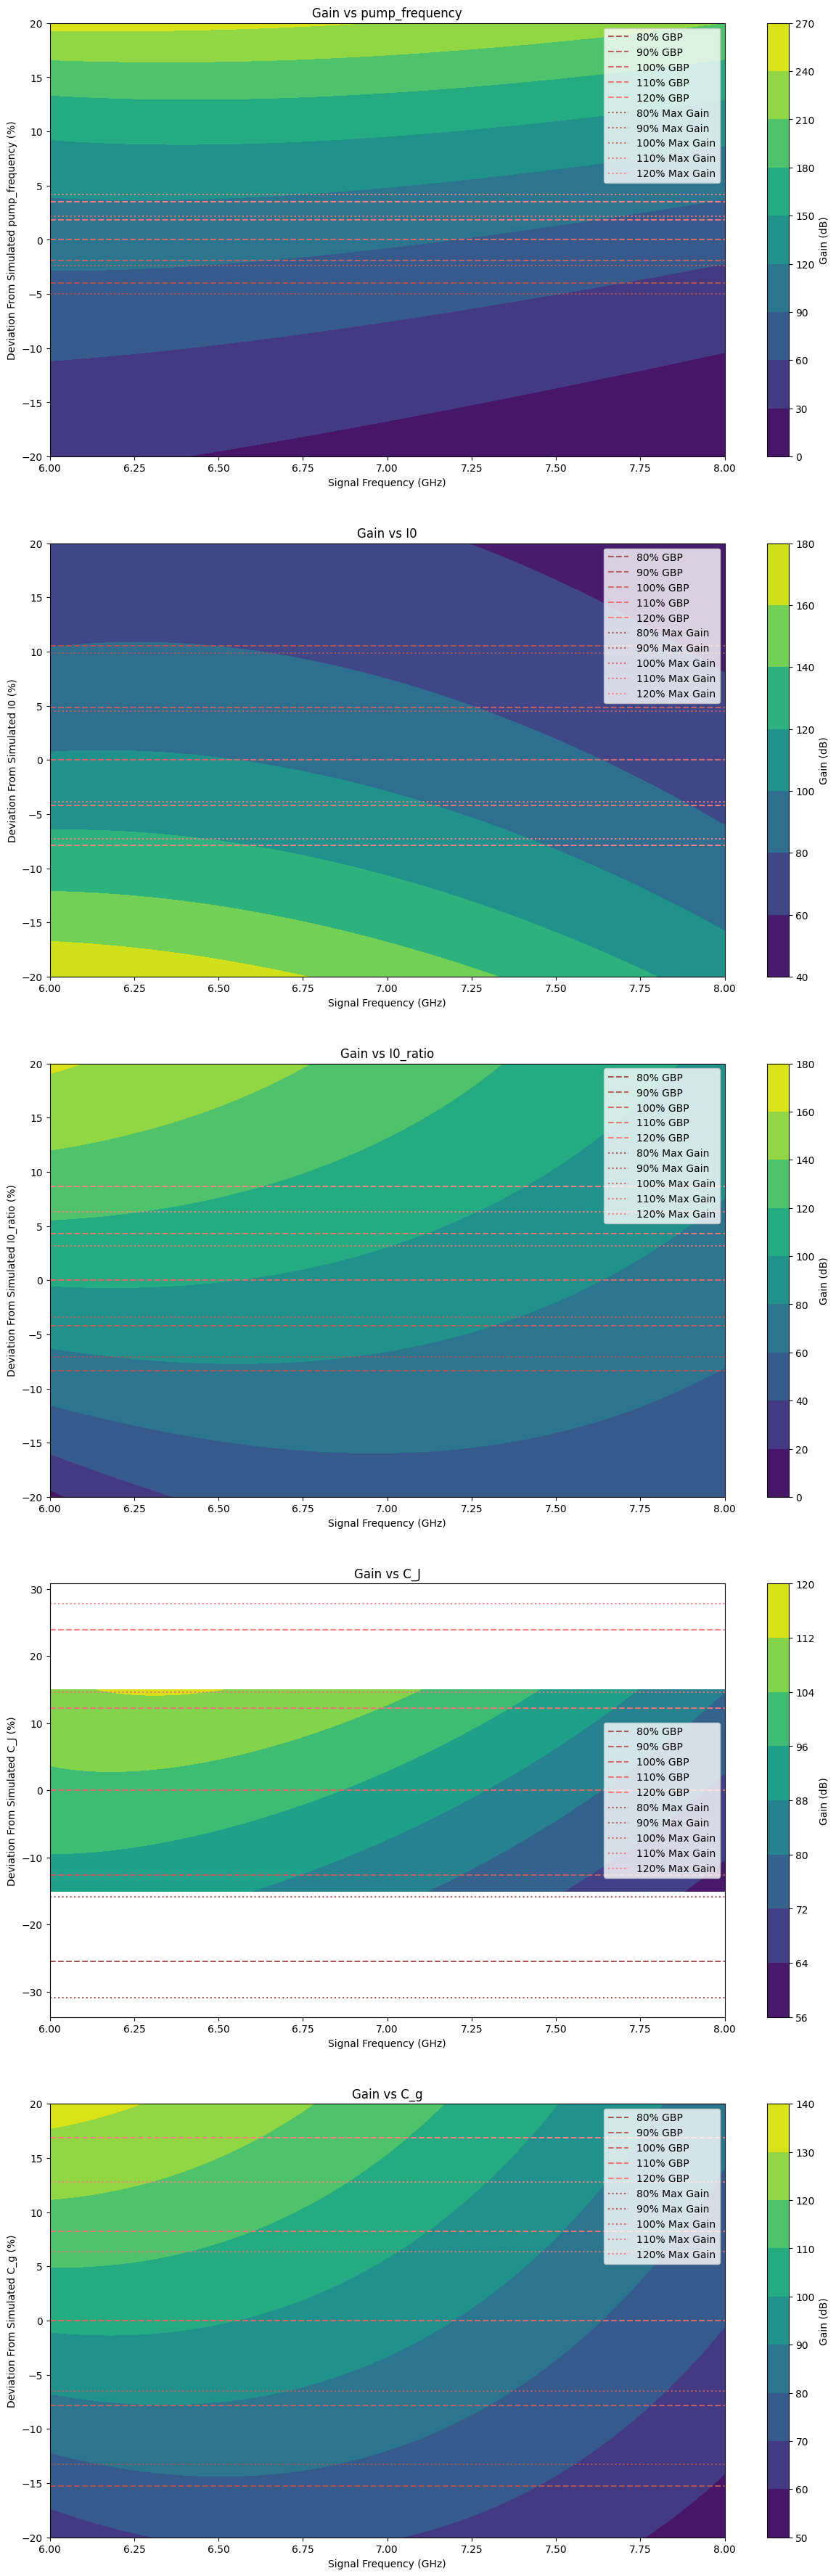

In [9]:
# Create a subplot grid
fig, axes = plt.subplots(5, 1, figsize=(15, 45))
fig.subplots_adjust(hspace=0.2)

#Define sensitivity as percent of parameter deviation required to change GBP by a given some amount
def gain_sensitivity_func (param_value, sim, freq_range, param_name, threshold, gain_stat_index=0):
    sim_copy = copy.deepcopy(sim)
    sim_copy.calculate_loop_parameters()
    gain_values_old_params = [sim_copy.gain(ws*np.pi*2e9) for ws in freq_range]

    setattr(sim_copy, param_name, param_value)
    sim_copy.calculate_loop_parameters()
    gain_values_new_params = [sim_copy.gain(ws*np.pi*2e9) for ws in freq_range]

    return (threshold)*gain_stats(freq_range[0], freq_range[-1], freq_range, gain_values_old_params)[gain_stat_index]/gain_stats(freq_range[0], freq_range[-1], freq_range, gain_values_new_params)[gain_stat_index] - 1

sens_thresholds = np.linspace(0.8, 1.2, 5)
gbp_sensitivities, avg_sensitivities, max_sensitivities = {}, {}, {}
omega_s_range = np.linspace(6, 8, 100)

# Vary different parameters and plot gain maps
for ax, param_values, param_name in zip(axes.flatten(),
                                       [pump_frequencies, I0_values, I0_ratio_values, C_J_values, C_g_values],
                                       ['pump_frequency','I0', 'I0_ratio', 'C_J', 'C_g']):
    gains, avg_gains = [], []
    gbp_sensitivities[param_name] = [round((fsolve(gain_sensitivity_func, 
                                            x0=getattr(sim_original, param_name),
                                            args=(sim_original, omega_s_range, param_name, th, 0))/getattr(sim_original, param_name) - 1)[0]*100,3) for th in sens_thresholds]
    max_sensitivities[param_name] = [round((fsolve(gain_sensitivity_func, 
                                            x0=getattr(sim_original, param_name),
                                            args=(sim_original, omega_s_range, param_name, th, 2))/getattr(sim_original, param_name) - 1)[0]*100,3) for th in sens_thresholds]
    for param_value in param_values:
        # Create a copy of sim_original for each iteration
        sim_copy = copy.deepcopy(sim_original)

        # Set the parameter value in the simulation copy
        setattr(sim_copy, param_name, param_value)
        sim_copy.calculate_loop_parameters()  # Recalculate loop parameters if needed
        gain_values = sim_copy.gain_vs_freq(omega_s_range)
        gains.append(gain_values)

    # Create a contour plot for the gain map
    X, Y = np.meshgrid(omega_s_range, [100*(param_value/sim_params[param_name]-1) for param_value in param_values])
    gains = np.array(gains)
    contour = ax.contourf(X, Y, gains, cmap='viridis')
    ax.set_xlabel('Signal Frequency (GHz)')
    ax.set_ylabel(f'Deviation From Simulated {param_name} (%)')
    ax.set_title(f'Gain vs {param_name}')

    for param_value, th in zip(gbp_sensitivities[param_name], sens_thresholds):
        ax.axhline(param_value, color=(th/sens_thresholds[-1], th/2/sens_thresholds[-1], th/2/sens_thresholds[-1]), linestyle='--', label=f'{int(th*100)}% GBP')

    for param_value, th in zip(max_sensitivities[param_name], sens_thresholds):
        ax.axhline(param_value, color=(th/sens_thresholds[-1], th/2/sens_thresholds[-1], th/2/sens_thresholds[-1]), linestyle=':', label=f'{int(th*100)}% Max Gain')

    ax.legend()
    # Add colorbar legend
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Gain (dB)')

# Show the plots
plt.show()

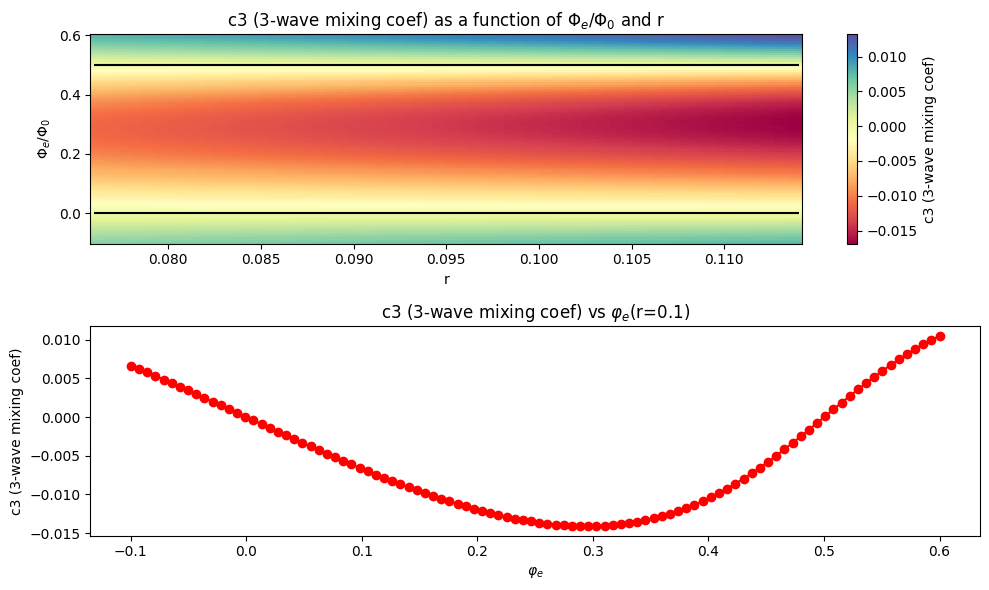

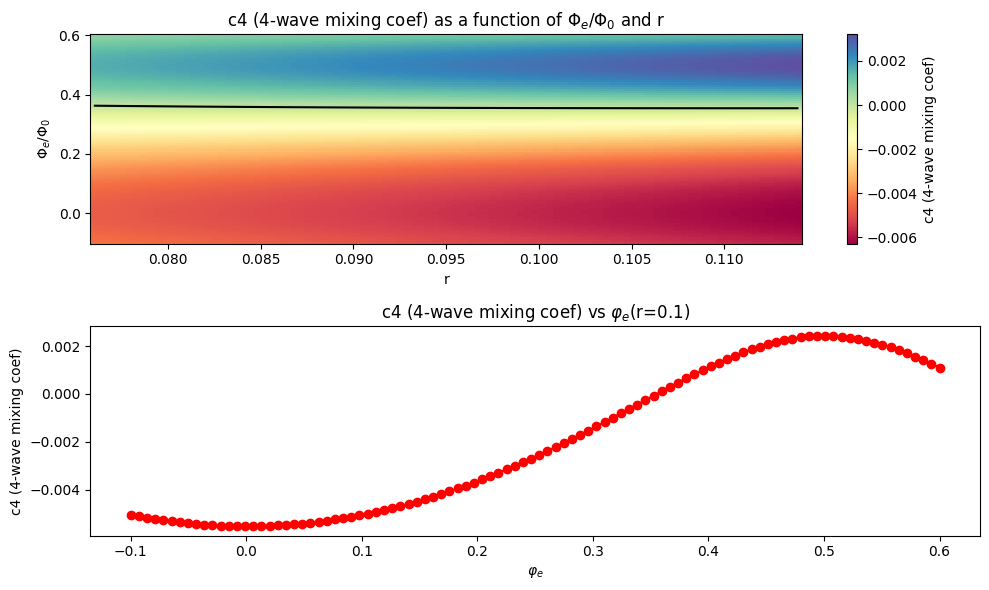

In [10]:
### SNAIL current simulation ###
snail = Snail(sim_params['C_g'], sim_params["I0"], 3)

# Define phi_e and r values
phis = np.linspace(-0.1, 0.6, 100)
rs = np.linspace(0.8*sim_params['I0_ratio'], 1.2*sim_params['I0_ratio'], 100)

# Plot heatmaps
snail.plot_heatmap(phis, rs, snail.c3, 'c3 (3-wave mixing coef)')

snail.plot_heatmap(phis, rs, snail.c4, 'c4 (4-wave mixing coef)')